In [1]:
from __future__ import print_function, division
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 150}

C:\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import ipyparallel as ipp
client = ipp.Client()
client[:].use_dill()
lbview = client.load_balanced_view()

In [3]:
import numpy as np
with client[:].sync_imports():
    import scipy
    import scipy.stats
client[:].push(dict(np=np))
import qinfer as qi
from talk_figures import SampleTimeHeuristic, UnknownT2Model, COSYModel
from functools import partial

importing scipy on engine(s)
importing scipy.stats on engine(s)


In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot-rq')

In [5]:
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['text.color'] = 'white'
plt.rcParams['grid.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.facecolor'] = '#444444'

In [6]:
nyquist_heuristic = partial(SampleTimeHeuristic, t_func=lambda k: 2750 * k / 2000)
exp_sparse_heuristic = partial(SampleTimeHeuristic, t_func=lambda k: 1.0049 ** k)

In [7]:
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', [
    '#D55E00', 
    '#56B4E9'
])

KeyboardInterrupt: 

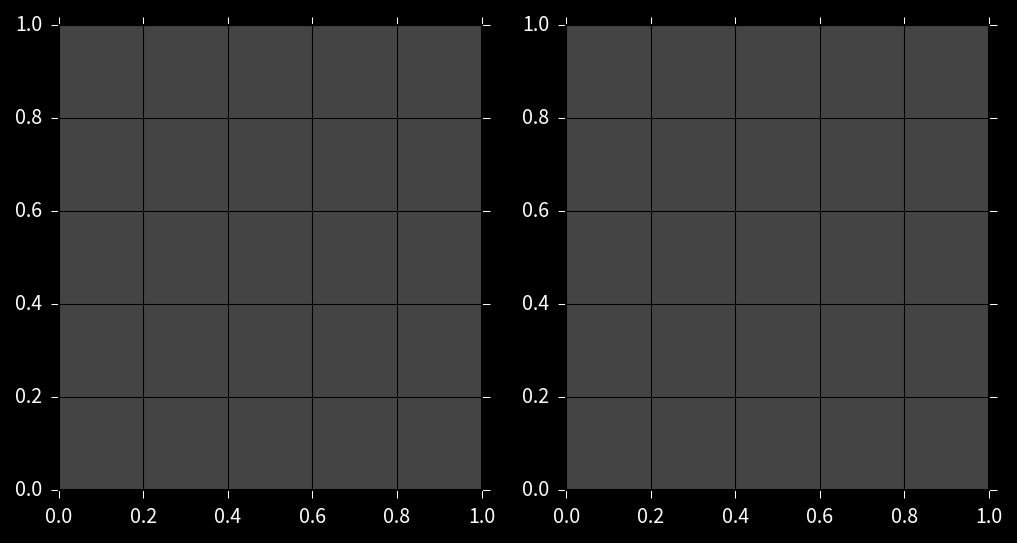

In [8]:
fig, subplots = plt.subplots(ncols=2, figsize=(8, 4))

for heuristic, label in (
        (nyquist_heuristic, r'Uniform'),
        (exp_sparse_heuristic, r'Exp.')
    ):
    perf = qi.perf_test_multiple(400,
        UnknownT2Model(), 10000,
        qi.ProductDistribution(
            qi.UniformDistribution([0, 1]),
            qi.NormalDistribution(0.001, 0.00025 ** 2)
        ),
        2000, heuristic,
        progressbar=qi.IPythonProgressBar,
        apply=lbview.apply,
        extra_updater_args={
            'resampler': qi.LiuWestResampler(a=0.9)
        }
    )
    risk_by_param = ((perf['est'] - perf['true']) ** 2).mean(axis=0).T
    
    for subplot, risk, param_name in zip(subplots, risk_by_param, map('${}$'.format, UnknownT2Model().modelparam_names)):
        subplot.semilogy(risk, label=label)
        subplot.set_title(param_name, loc='left')
        subplot.set_xlabel('Bits of Data')
        
subplots[0].set_ylabel('Mean Squared Error')
        
plt.legend(ncol=3, bbox_to_anchor=(1, 1.105), columnspacing=1.0)
plt.savefig('figures/unknown-t2.png', dpi=250, facecolor='k', frameon=False)

### QBS Data ###

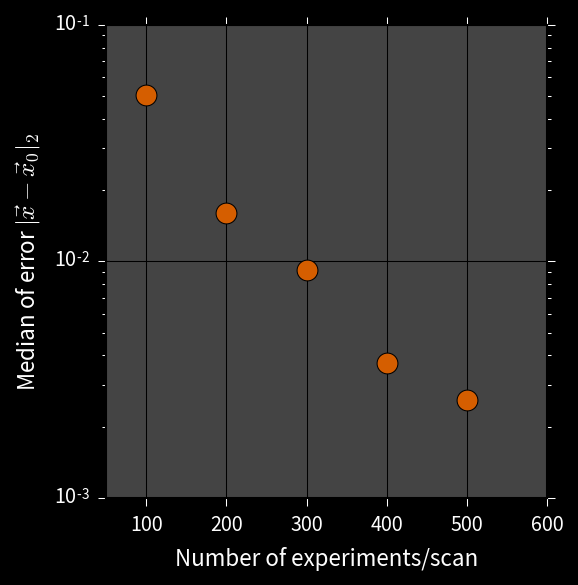

In [59]:
x = [100, 200, 300, 400, 500]
y = [0.0506, 0.0160, 0.0092, 0.0037, 0.0026]

fig = plt.figure(figsize=(4, 4))
plt.semilogy(x, y, 'o', markersize=10);
plt.xlim((50, 600))
plt.xlabel('Number of experiments/scan')
plt.ylabel(r'Median of error $|\vec{x}-\vec{x}_{0}|_2$')
fig.tight_layout()

plt.savefig('./figures/qbs-error-per-scan.png', dpi=500, facecolor='k', frameon=False)

### Impovrishment ###

In [60]:
particles_good = np.random.randn(1200, 2)

particles_bad = np.random.uniform(-4, 4, (400, 2))
wts_bad = np.product(scipy.stats.norm.pdf(particles_bad), axis=1)
wts_bad /= wts_bad.sum()

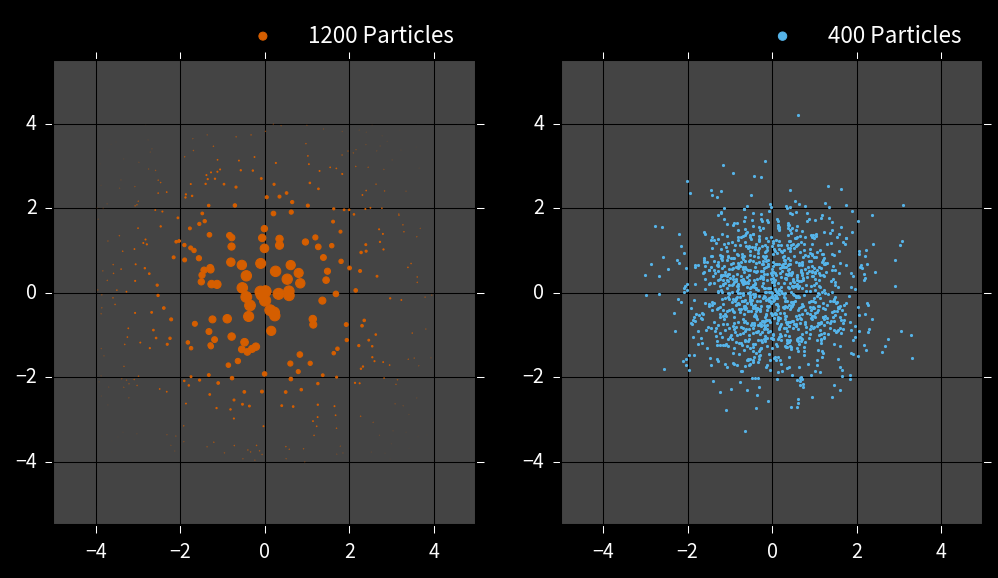

In [61]:
try: style_cycle = plt.rcParams['axes.prop_cycle']()
except:
    from cycler import cycler
    style_cycle = iter(cycler('color', plt.rcParams['axes.color_cycle']))
    
plt.figure(figsize=(8, 4))
ax = plt.subplot(1, 2, 1)
plt.scatter(particles_bad[:, 0], particles_bad[:, 1], s=1200 * wts_bad, **style_cycle.next())
plt.legend(['1200 Particles'],bbox_to_anchor=(1, 1.125), scatterpoints=1)
plt.gca().set_aspect('equal')

plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.scatter(particles_good[:, 0], particles_good[:, 1], s=1200 / len(particles_good), **style_cycle.next())
plt.legend(['400 Particles'],bbox_to_anchor=(1, 1.125), scatterpoints=1, markerscale=4)
plt.gca().set_aspect('equal')

plt.savefig('figures/impovrishment.png', format='png', dpi=300, frameon=False, facecolor="black")

### Example: Rabi/Ramsey ###

In [9]:
w = 70.3
w_max = 100.0

ts = 2 * np.pi * (1 + np.arange(100)) / (10 * w_max)


ideal_signal = np.sin(w * ts / 2) ** 2

In [10]:
all_counts = []
n_shotses = (1, 10, 100)
for n_shots in n_shotses:
    all_counts.append(np.random.binomial(n=n_shots, p=ideal_signal))

In [11]:
from matplotlib.font_manager import FontManager, FontProperties
condensed = FontProperties()
condensed.set_family('Open Sans Condensed')

In [12]:
fm = FontManager()

In [13]:
fm.findfont(condensed)

u'c:\\windows\\fonts\\opensans-condbold.ttf'

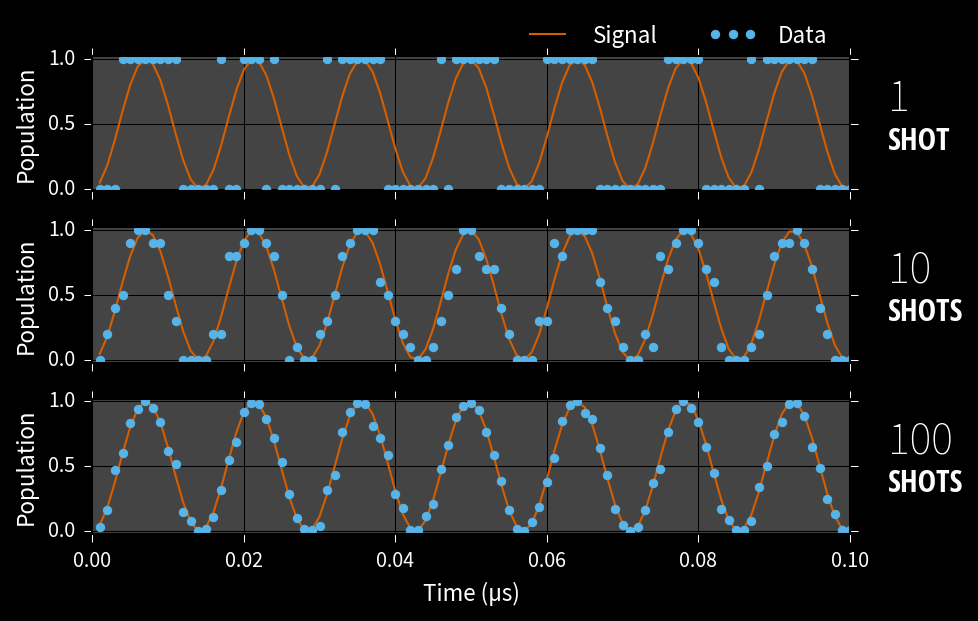

In [16]:
fig, axes = plt.subplots(nrows=len(all_counts), sharex=True)

for axis, n_shots, counts in zip(axes, n_shotses, all_counts):
    plt.sca(axis)
    plt.plot(ts / (2 * np.pi), ideal_signal, label='Signal', lw=1)
    plt.plot(ts / (2 * np.pi), counts / n_shots, '.', label='Data', markersize=8)
    plt.ylabel(r'Population')
    plt.ylim(-0.02, 1.02)
    plt.yticks([0, 0.5, 1])
    plt.xlim(0, np.max(ts / (2 * np.pi)))
    
    plt.text(1.05, 0.52,
        "{}".format(n_shots),
        horizontalalignment='left',
        verticalalignment='bottom',
        transform=axis.transAxes,
        fontsize=22,
        fontweight=100
    )
    plt.text(1.05, 0.48,
        "SHOT{}".format("S" if n_shots > 1 else ""),
        horizontalalignment='left',
        verticalalignment='top',
        transform=axis.transAxes,
        fontsize=15,
        fontproperties=condensed
    )

plt.sca(axes[0])
plt.legend(ncol=2, bbox_to_anchor=(1, 1.4), numpoints=3)

plt.sca(axes[-1])
plt.xlabel(u'Time (µs)')

plt.tight_layout()
plt.savefig('figures/rabi-example-signal.png', format='png', dpi=300, frameon=False, facecolor="black", bbox_inches='tight')

In [95]:
ideal_spectrum = np.abs(np.fft.fftshift(np.fft.fft(ideal_signal - ideal_signal.mean())))**2
spectrum = np.abs(np.fft.fftshift(np.fft.fft((counts - counts.mean()) / n_shots)))**2
ft_freq = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(n=len(counts), d=ts[1] - ts[0]))

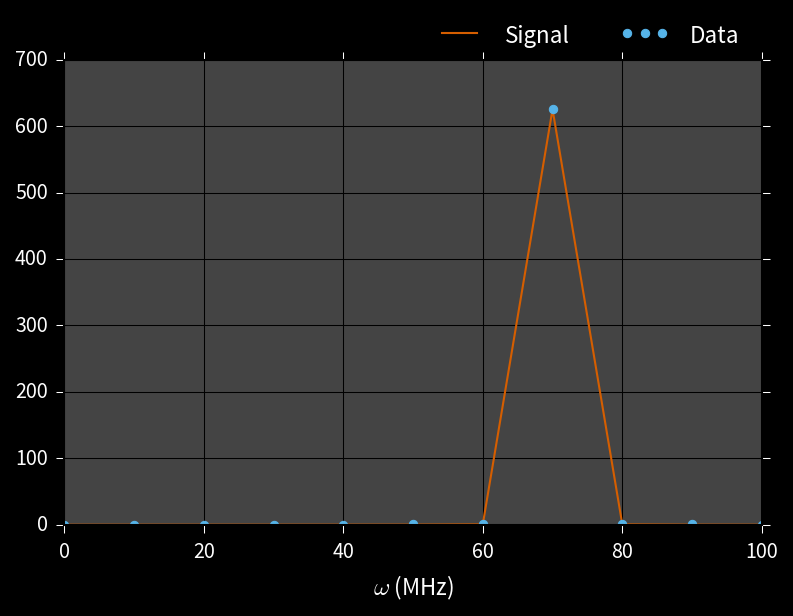

In [96]:
plt.plot(ft_freq, ideal_spectrum, lw=1, label='Signal')
plt.plot(ft_freq, spectrum, '.', label='Data', markersize=8)
ylim = plt.ylim()
# plt.vlines(w, *ylim)
plt.xlim(xmin=0, xmax=100)
# plt.ylim(*ylim)
plt.legend(ncol=2, bbox_to_anchor=(1, 1.125), numpoints=3)
plt.xlabel('$\omega$ (MHz)')
plt.savefig('figures/rabi-example-spectrum.png', format='png', dpi=300, frameon=False, facecolor="black")

## COSY Model ##

In [26]:
def cosy_heuristic(updater, n_meas=10, base=65 / 64):
    N = len(updater.data_record)
    t_ratio = np.random.random()
    expparams = np.zeros((1,), dtype=updater.model.expparams_dtype)
    expparams['t'] = np.array([t_ratio, 1 - t_ratio]) * base ** N
    expparams['n_meas'] = n_meas
    return expparams

In [27]:
cosy_model = qi.BinomialModel(COSYModel())
cosy_prior = qi.UniformDistribution([[0, 1]] * 3)

In [28]:
cosy_performance = qi.perf_test_multiple(100,
    cosy_model, 3000, cosy_prior,
    300, partial(partial, cosy_heuristic, base=1.02),
    apply=lbview.apply,
    progressbar=qi.IPythonProgressBar
)

In [35]:
loss_J = (cosy_performance['est'][:, :, 2] - cosy_performance['true'][:, :, 2]) ** 2

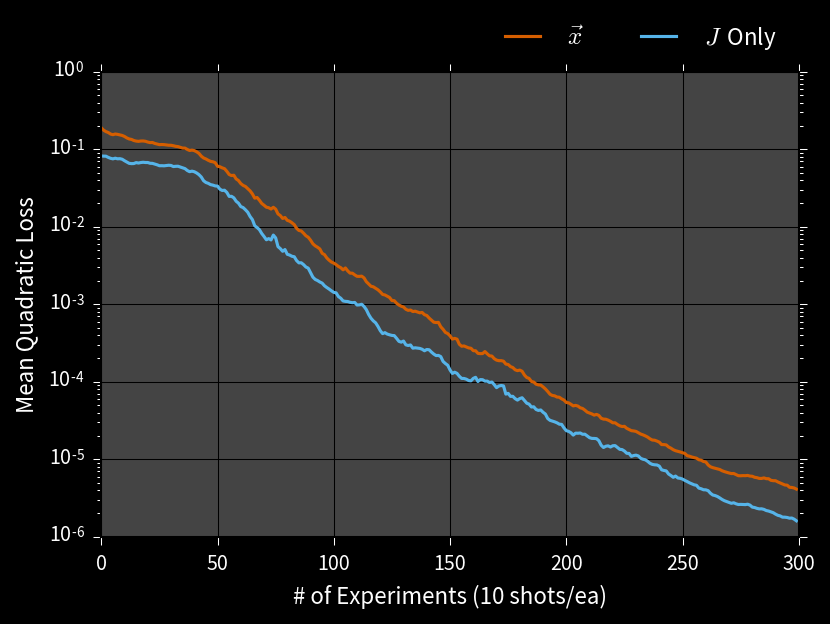

In [40]:
plt.semilogy(np.mean(cosy_performance['loss'], axis=0), label=r'$\vec{x}$')
plt.semilogy(np.mean(loss_J, axis=0), label=r'$J\,$ Only')
plt.xlabel('# of Experiments (10 shots/ea)')
plt.ylabel('Mean Quadratic Loss')
plt.legend(ncol=2, bbox_to_anchor=(1, 1.15))
plt.savefig('figures/cosy-loss.png', format='png', dpi=300, frameon=False, facecolor="black")

### Rejection Sampling ###

In [38]:
xs = np.random.random((300,))
us = np.random.random((300,))
likes = np.sin(xs * 3 * np.pi / 2) ** 2

sorts = np.argsort(xs)
accepts = us < likes

In [52]:
posts = likes[sorts] / np.trapz(likes[sorts], x=xs[sorts])

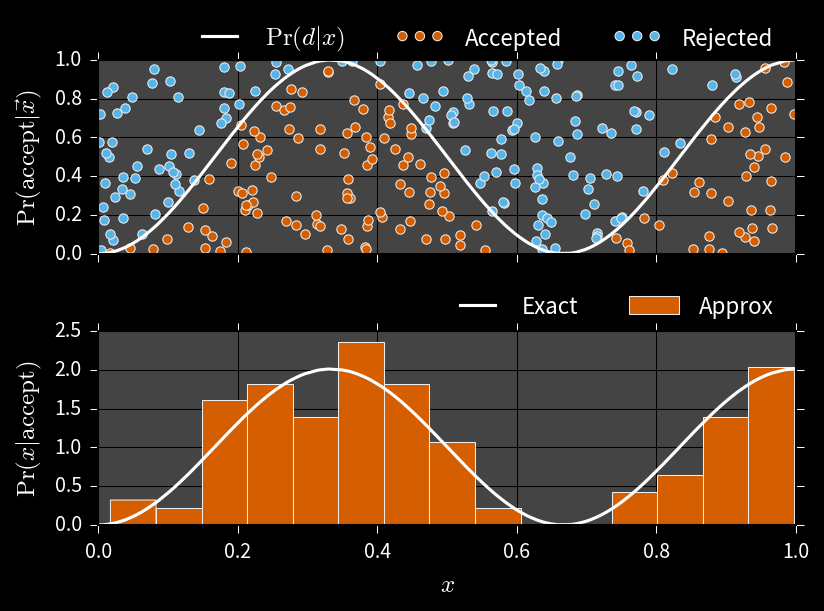

In [66]:
fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, sharex=True)
plt.subplots_adjust(hspace=0.4)

ax_top.plot(xs[sorts], likes[sorts], 'w', label=r'$\Pr(d | x)$')
ax_top.scatter(xs[accepts], us[accepts], c='#D55E00', label='Accepted')
ax_top.scatter(xs[~accepts], us[~accepts], c='#56B4E9', label='Rejected')
# plt.xlim(0, 1)
ax_top.set_ylim(0, 1)
# plt.xlabel('$x$')
ax_top.set_ylabel(r'$\Pr(\mathrm{accept} | \vec{x})$')
ax_top.legend(ncol=3, bbox_to_anchor=(1, 1.3), scatteryoffsets=[0.5])

ax_bottom.plot(xs[sorts], posts, 'w', label='Exact')
ax_bottom.hist(xs[accepts], bins=15, normed=True, label='Approx');
ax_bottom.set_xlabel('$x$')
ax_bottom.set_ylabel(r'$\Pr(x | \mathrm{accept})$')
ax_bottom.set_xlim(0, 1)
ax_bottom.legend(ncol=2, bbox_to_anchor=(1, 1.3), scatteryoffsets=[0.5])

plt.savefig('figures/rejs-example.png', format='png', dpi=300, frameon=False, facecolor="black")

## Random Walk ##

In [10]:
prior = qi.UniformDistribution([0, 1])
true_params = np.array([[0.5]])
model = qi.RandomWalkModel(qi.BinomialModel(qi.SimplePrecessionModel()), qi.NormalDistribution(0, 0.01**2))
updater = qi.SMCUpdater(model, 2000, prior)

expparams = np.array([(np.pi / 2, 40)], dtype=model.expparams_dtype)

data_record = []
trajectory = []
estimates = []

for idx in range(1000):
    datum = model.simulate_experiment(true_params, expparams)
    true_params = np.clip(model.update_timestep(true_params, expparams)[:, :, 0], 0, 1)
    
    updater.update(datum, expparams)

    data_record.append(datum)
    trajectory.append(true_params[0, 0])
    estimates.append(updater.est_mean()[0])

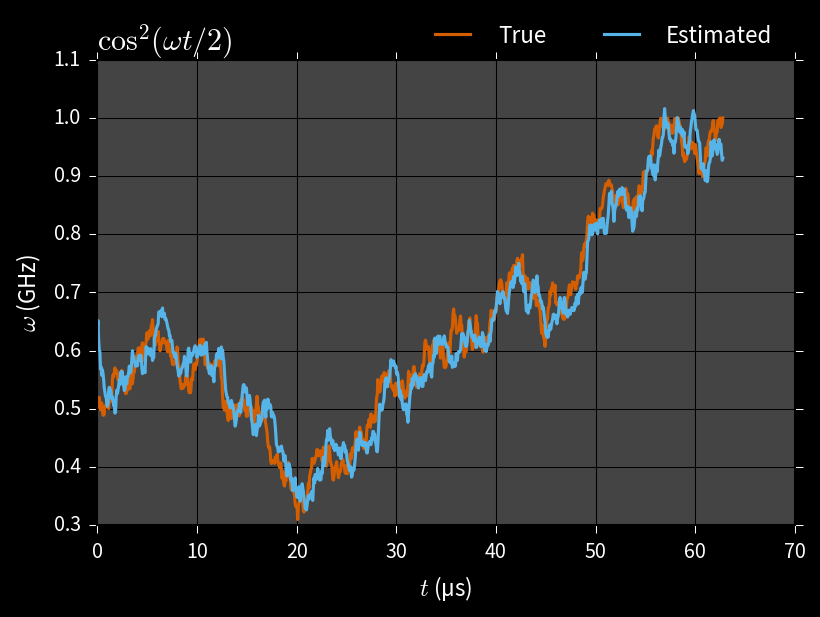

In [17]:
ts = 40 * np.pi / 2 * np.arange(len(data_record)) / 1e3
plt.plot(ts, trajectory, label='True')
plt.plot(ts, estimates, label='Estimated')
plt.xlabel(u'$t$ (µs)')
plt.ylabel(r'$\omega$ (GHz)')
plt.legend(ncol=2, bbox_to_anchor=(1, 1.125))
plt.title(r"$\cos^2(\omega t / 2)$", loc='left')
plt.savefig('figures/rabi-random-walk.png', format='png', dpi=300, frameon=False, facecolor="black")

## RB

In [17]:
n_exp = 200
seq_lengths = 1 + np.arange(n_exp)
n_shots = 200

In [19]:
counts = np.random.binomial(n_shots, 0.5 * 0.995 ** seq_lengths + 0.5)

In [22]:
>>> model = qi.BinomialModel(
...     qi.RandomizedBenchmarkingModel()
... )

In [23]:
>>> prior = qi.PostselectedDistribution(
...     qi.ProductDistribution(
...         qi.UniformDistribution([0.8, 1]),
...         qi.MultivariateNormalDistribution(
...             np.array([0.498, 0.499]),
...             np.diag([0.004, 0.002]) ** 2
...         )
...     ), model)

In [24]:
>>> updater = qi.SMCUpdater(model, 8000, prior)
>>> for idx_exp in range(n_exp):
...     expparams = np.array(
...         [(seq_lengths[idx_exp], n_shots)],
...         dtype=model.expparams_dtype)
...     updater.update(counts[idx_exp], expparams)

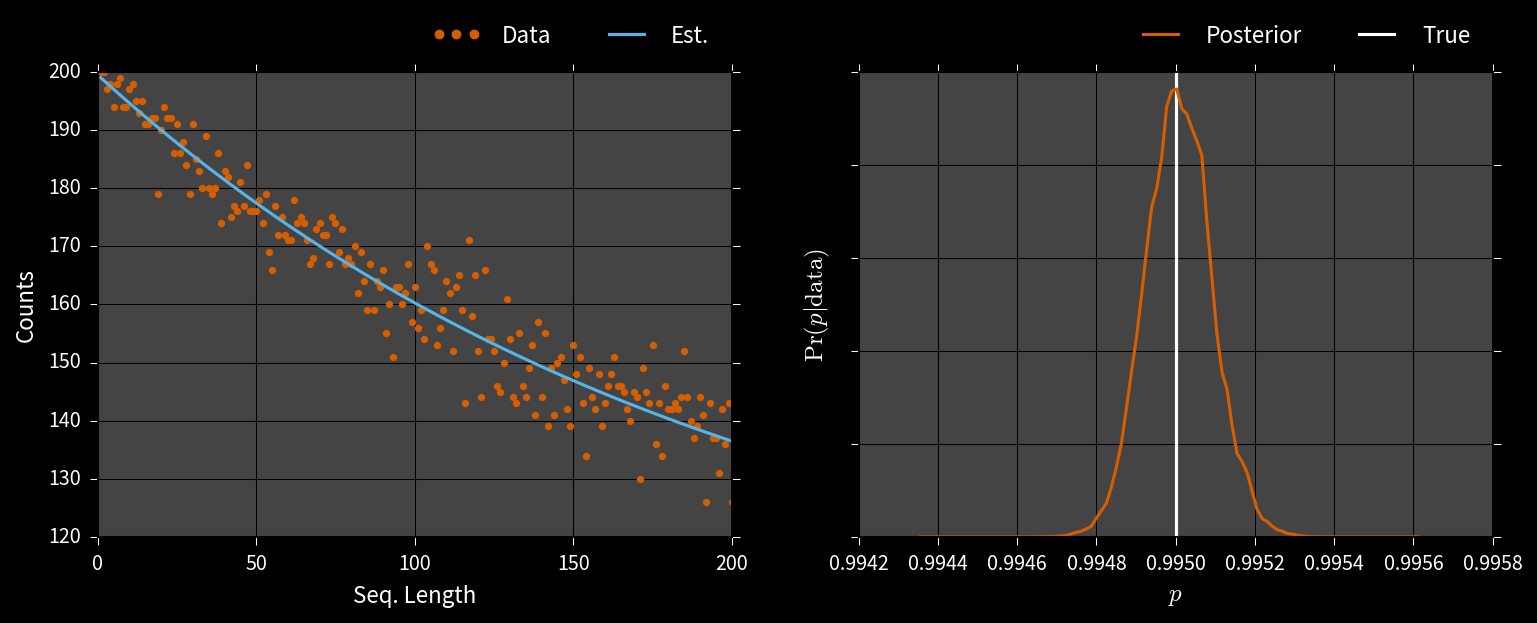

In [55]:
fig, (left, right) = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

plt.sca(right)
updater.plot_posterior_marginal(idx_param=0)
plt.vlines(0.995, *(plt.ylim() + ('w',)))
plt.legend(['Posterior', 'True'], ncol=2, bbox_to_anchor=(1, 1.15))
plt.ylabel(r'$\Pr(p | \mathrm{data})$')
right.yaxis.set_ticklabels([])

plt.sca(left)
plt.plot(seq_lengths, counts, '.', label='Data')
p, A, B = updater.est_mean()
plt.plot(seq_lengths, n_shots * (A * p ** seq_lengths + B), label='Est.')
plt.legend(ncol=2, numpoints=3, markerscale=1.4, bbox_to_anchor=(1, 1.15))
plt.xlabel('Seq. Length')
plt.ylabel('Counts')

plt.savefig('figures/rb-custom-updater.png', format='png', dpi=300, frameon=False, facecolor="black")

## Diffusive Coin Example ##

In [13]:
class DiffusiveCoinModel(qi.Model):
    @property
    def n_modelparams(self): return 2
    @property
    def modelparam_names(self): return ['p', r'\sigma']
    @property
    def expparams_dtype(self): return [('t', float)]
    @property
    def is_n_outcomes_constant(self): return True
    def are_models_valid(self, modelparams):
        return np.all([
            modelparams[:, 0] >= 0,
            modelparams[:, 0] <= 1,
            modelparams[:, 1] >= 0
        ], axis=0)
    def n_outcomes(self, expparams): return 2
    
    def likelihood(self, outcomes, modelparams, expparams):
        super(DiffusiveCoinModel, self).likelihood(outcomes, modelparams, expparams)
        return qi.Model.pr0_to_likelihood_array(outcomes, 1 - modelparams[:, 0, None])
    
    def update_timestep(self, modelparams, expparams):
        p, sigma = modelparams.T
        t = expparams['t']
        
        p_new = np.clip((np.random.randn(*p.shape) * sigma)[:, None] * np.sqrt(t) + p[:, None], 0, 1)
        mps_new = np.empty((p.shape[0], 2, t.shape[0]))
        mps_new[:, 0, :] = p_new
        mps_new[:, 1, :] = sigma[:, None]
        
        return mps_new

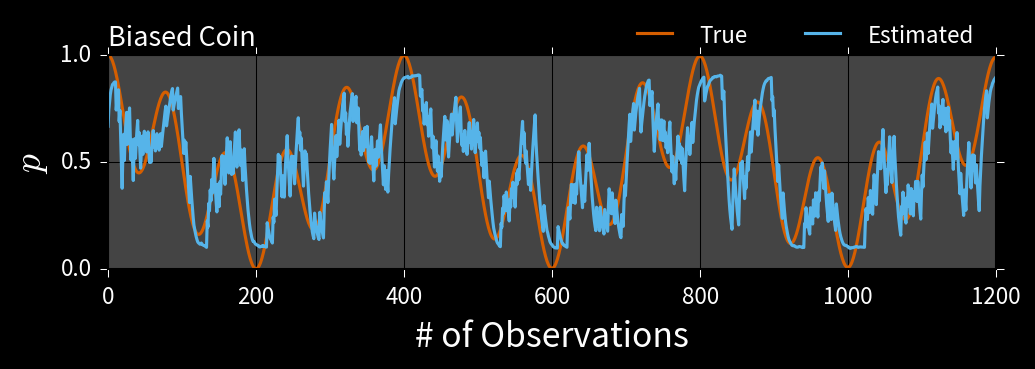

In [15]:
prior = qi.UniformDistribution([[0, 1], [0, 1]])
model = DiffusiveCoinModel()
true = prior.sample(1)
t = 0.03
expparams = np.array([(t,)], dtype=model.expparams_dtype)
updater = qi.smc.SMCUpdater(model, 2000, prior)

true_hist = []
est_hist = []
for idx_exp in xrange(1200):
    true = (np.array([[np.cos(idx_exp * np.pi / 40), 0]]) + 1) / 4 +  (np.array([[np.cos(idx_exp * np.pi / 197), 0]]) + 1) / 4
    outcome = model.simulate_experiment(true, expparams)
    updater.update(outcome, expparams)
    
    est_hist.append(updater.est_mean()[0])
    true_hist.append(true[:, 0])
    
plt.figure(figsize=(7, 2.5))
plt.plot(range(1200), true_hist, label='True')
plt.plot(range(1200), est_hist, label='Estimated')
plt.xlabel(r'# of Observations', size=18)
plt.ylabel(r'$p$', size=18)
plt.yticks([0, 0.5, 1], size=12)
plt.xticks(size=12)
plt.legend(ncol=2, bbox_to_anchor=(1, 1.25))
plt.title("Biased Coin", loc='left')
plt.tight_layout()
plt.savefig('figures/diffusive-coin.png', format='png', dpi=300, frameon=False, facecolor="black")

### LF RejF ###

In [8]:
def lfrf_update(sim, datum, mean, var, m=500, batch_size=100):
    xs = []
    
    while len(xs) < m:
        xs_batch = np.sqrt(var) * np.random.randn(batch_size) + mean
        xs_batch = xs_batch[xs_batch >= 0]
        sim_data = sim(xs_batch)
        xs += xs_batch[sim_data == datum].tolist()
        
    return np.mean(xs[:m]), np.var(xs[:m])

In [9]:
def cos_sim(omega, t):
    return np.random.random() < np.cos(omega * t / 2) ** 2

In [10]:
def lfrf_errors(n_trials=500, n_exp=100, m=500):
    err_hist = []
    for idx_trial in range(n_trials):
        mean = 0.5
        var = 1 / 12
        true = np.random.random()
        mean_hist = []
        var_hist = []

        for idx_exp in range(n_exp):
            t = 1 / np.sqrt(var)
            w_ = mean
            datum = cos_sim(true, t)
            mean, var = lfrf_update(partial(cos_sim, t=t), datum, mean, var, m=m)
            mean_hist.append(mean)
            var_hist.append(var)

        err_hist.append((np.array(mean_hist) - true) ** 2)
    return np.array(err_hist)

In [11]:
err_hists = {
    m: lfrf_errors(400, 100, m)
    for m in (50, 400)
}

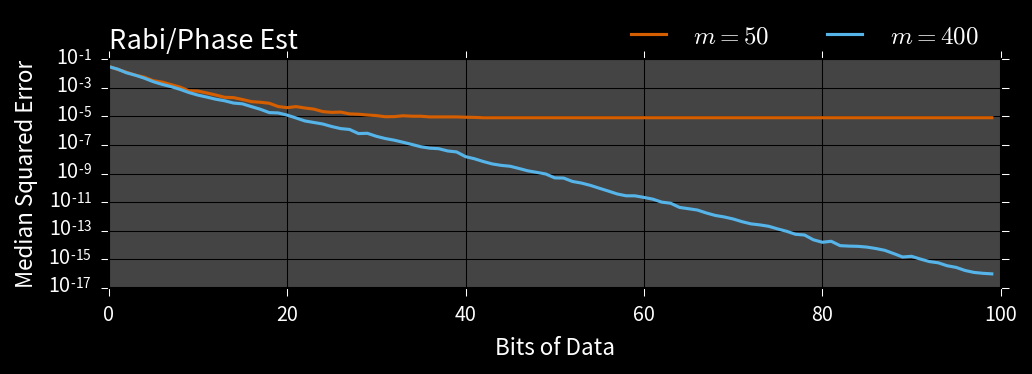

In [13]:
plt.figure(figsize=(7, 2.5))
plt.semilogy(np.median(err_hists[50], axis=0), label='$m = 50$')
plt.semilogy(np.median(err_hists[400], axis=0), label='$m = 400$')
plt.xlabel('Bits of Data')
plt.ylabel('Median Squared Error')
plt.legend(ncol=2, bbox_to_anchor=(1, 1.25))
plt.title(r'Rabi/Phase Est', loc='left')
plt.tight_layout()
plt.savefig('figures/lfrf.png', format='png', dpi=300, frameon=False, facecolor="black")